In [54]:
!pip install gradio

In [55]:
# @title Import Libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import gradio as gr
import io
from PIL import Image


In [56]:
# @title Room Layout and Dataset generation
def generate_layout(room_w, room_h, furnitures, spacing=1):
    """
    Place furniture sequentially in a row until it doesn't fit, then start a new row.
    This ensures non-overlap and fits within the room boundaries.
    """
    positions = []
    current_x = spacing
    current_y = spacing
    row_height = 0
    for (w, h) in furnitures:
        if current_x + w > room_w - spacing:
            current_x = spacing
            current_y += row_height + spacing
            row_height = h
        else:
            row_height = max(row_height, h)
        positions.append((current_x, current_y))
        current_x += w + spacing
    return positions

def generate_dataset(num_samples=100):
    """
    Generates synthetic samples.
    Features: room_width, room_height, f1_width, f1_height, f2_width, f2_height, f3_width, f3_height
    Labels: positions for each furniture item: [f1_x, f1_y, f2_x, f2_y, f3_x, f3_y]
    """
    X = []  # Input features
    y = []  # Output placements
    for _ in range(num_samples):
        room_w = np.random.randint(10, 16)
        room_h = np.random.randint(10, 16)
        # Generate random sizes for 3 furniture items:
        f1_w = np.random.uniform(3, 5)
        f1_h = np.random.uniform(1, 2)
        f2_w = np.random.uniform(2, 3)
        f2_h = np.random.uniform(2, 3)
        f3_w = np.random.uniform(1, 2)
        f3_h = np.random.uniform(1, 2)
        furnitures = [(f1_w, f1_h), (f2_w, f2_h), (f3_w, f3_h)]
        positions = generate_layout(room_w, room_h, furnitures, spacing=1)

        X.append([room_w, room_h, f1_w, f1_h, f2_w, f2_h, f3_w, f3_h])
        flat_positions = []
        for pos in positions:
            flat_positions.extend(pos)
        y.append(flat_positions)
    return np.array(X), np.array(y)

# Generate dataset and print shapes
X, y = generate_dataset(800)
print("Dataset shapes (features, labels):", X.shape, y.shape)


Dataset shapes (features, labels): (800, 8) (800, 6)


In [57]:
# @title Training Model
model = Sequential([
    Dense(32, activation='relu', input_dim=8),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(6, activation='linear')  # 6 outputs for x,y positions of 3 furniture pieces
])
model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,678 (18.27 KB)

 Trainable params: 4,678 (18.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 10.3142 - val_loss: 3.5755
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3847 - val_loss: 2.9097
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1047 - val_loss: 2.7550
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9174 - val_loss: 2.5392
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7030 - val_loss: 2.3693
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3291 - val_loss: 2.1202
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0465 - val_loss: 1.9020
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9139 - val_loss: 1.7259
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6975 - val_loss: 1.7488
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5887 - val_loss: 1.5489
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5353 - val_loss: 1.5679
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.

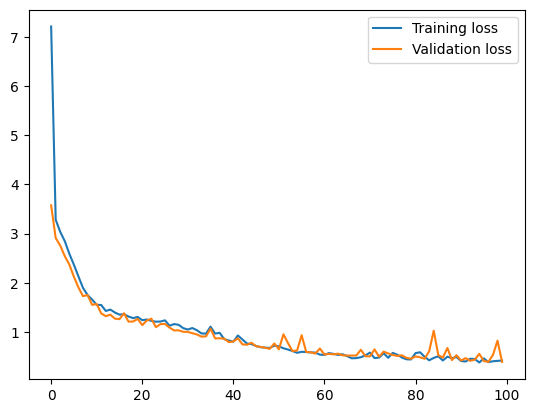

In [58]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [59]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate a separate test dataset
X_test, y_test = generate_dataset(num_samples=200)  # 100 test samples for evaluation

# Predict positions using the trained model
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Evaluation Metrics on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Optional: Detailed per-coordinate analysis
# y_test and y_pred are shape (100, 6) where each row is [f1_x, f1_y, f2_x, f2_y, f3_x, f3_y]
for i, label in enumerate(["F1_x", "F1_y", "F2_x", "F2_y", "F3_x", "F3_y"]):
    mse_coord = mean_squared_error(y_test[:, i], y_pred[:, i])
    mae_coord = mean_absolute_error(y_test[:, i], y_pred[:, i])
    print(f"{label} - MSE: {mse_coord:.4f}, MAE: {mae_coord:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Evaluation Metrics on Test Set:
Mean Squared Error (MSE): 0.5276
Mean Absolute Error (MAE): 0.3144
R² Score: 0.4676
F1_x - MSE: 0.0032, MAE: 0.0459
F1_y - MSE: 0.0051, MAE: 0.0589
F2_x - MSE: 0.7008, MAE: 0.4227
F2_y - MSE: 0.1633, MAE: 0.2080
F3_x - MSE: 1.9285, MAE: 0.7846
F3_y - MSE: 0.3648, MAE: 0.3661


In [60]:
# @title Finding Overlapps and Outof bounds
def is_overlapping(rect1, rect2):
    """
    Checks if two rectangles overlap.
    Each rectangle is defined as (x, y, width, height).
    """
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    if x1 + w1 <= x2 or x2 + w2 <= x1 or y1 + h1 <= y2 or y2 + h2 <= y1:
        return False
    return True

def find_non_overlapping_position(w, h, placed_rectangles, room_w, room_h, step=0.5):
    """
    Scans the room in a grid to find a position for a furniture piece of size (w, h)
    that does not overlap any already placed rectangles.
    """
    # Use np.arange to iterate over possible positions
    for y in np.arange(0, room_h - h + step, step):
        for x in np.arange(0, room_w - w + step, step):
            candidate = (x, y, w, h)
            if all(not is_overlapping(candidate, r) for r in placed_rectangles):
                return (x, y)
    # If no non-overlapping position is found, return a fallback (clip inside room)
    return (max(0, room_w - w), max(0, room_h - h))

def avoid_overlap(positions, furnitures, room_w, room_h, step=0.5):
    """
    For each predicted furniture position, ensure that it is within the room and
    does not overlap previously placed items. If a conflict is detected, a grid search
    is performed to find a valid position.
    """
    placed = []  # List of rectangles already placed (x, y, width, height)
    adjusted_positions = []
    for (x, y), (w, h) in zip(positions, furnitures):
        # First, clip the initial guess to ensure it's inside the room
        x = np.clip(x, 0, room_w - w)
        y = np.clip(y, 0, room_h - h)
        candidate = (x, y, w, h)
        # Check if candidate overlaps any already placed rectangle
        if all(not is_overlapping(candidate, (px, py, pw, ph)) for (px, py, pw, ph) in placed):
            adjusted_positions.append((x, y))
            placed.append(candidate)
        else:
            # Find an alternative non-overlapping position using grid search
            new_x, new_y = find_non_overlapping_position(w, h, placed, room_w, room_h, step)
            adjusted_positions.append((new_x, new_y))
            placed.append((new_x, new_y, w, h))
    return adjusted_positions


In [61]:
# @title Typical Visualization
def visualize_layout(room_w, room_h, furnitures, positions):
    fig, ax = plt.subplots(figsize=(6,6))
    # Draw room outline
    room_rect = plt.Rectangle((0, 0), room_w, room_h, fill=None, edgecolor='black', lw=2)
    ax.add_patch(room_rect)

    colors = ['red', 'blue', 'green']
    labels = ['Furniture 1', 'Furniture 2', 'Furniture 3']
    for i, ((fw, fh), (fx, fy)) in enumerate(zip(furnitures, positions)):
        rect = plt.Rectangle((fx, fy), fw, fh, color=colors[i], alpha=0.5, label=labels[i])
        ax.add_patch(rect)
        ax.text(fx + fw/2, fy + fh/2, labels[i], color='white', ha='center', va='center')

    ax.set_xlim(0, room_w)
    ax.set_ylim(0, room_h)
    ax.set_aspect('equal')
    plt.title("Predicted Furniture Layout")
    plt.legend()
    plt.show()

# def test_layout():
#     # Generate a new random room and furniture sizes
#     room_w = np.random.randint(10, 16)
#     room_h = np.random.randint(10, 16)
#     f1_w = np.random.uniform(3, 5)
#     f1_h = np.random.uniform(1, 2)
#     f2_w = np.random.uniform(2, 3)
#     f2_h = np.random.uniform(2, 3)
#     f3_w = np.random.uniform(1, 2)
#     f3_h = np.random.uniform(1, 2)
#     furnitures = [(f1_w, f1_h), (f2_w, f2_h), (f3_w, f3_h)]

#     input_features = np.array([[room_w, room_h, f1_w, f1_h, f2_w, f2_h, f3_w, f3_h]])
#     pred = model.predict(input_features)[0]
#     # Raw predicted positions
#     positions = [(pred[0], pred[1]), (pred[2], pred[3]), (pred[4], pred[5])]
#     # Adjust positions to avoid overlaps and out-of-bound placements
#     positions = avoid_overlap(positions, furnitures, room_w, room_h)

#     print("Room dimensions:", room_w, "x", room_h)
#     print("Furniture sizes:", furnitures)
#     print("Adjusted positions:", positions)
#     visualize_layout(room_w, room_h, furnitures, positions)

# # Run a test layout
# test_layout()


In [62]:
# @title Prediction layout for user input
def predict_layout(room_w, room_h, f1_w, f1_h, f2_w, f2_h, f3_w, f3_h):
    # Prepare input features and predict raw furniture placements
    input_features = np.array([[room_w, room_h, f1_w, f1_h, f2_w, f2_h, f3_w, f3_h]])
    pred = model.predict(input_features)[0]
    positions = [(pred[0], pred[1]), (pred[2], pred[3]), (pred[4], pred[5])]
    furnitures = [(f1_w, f1_h), (f2_w, f2_h), (f3_w, f3_h)]
    # Adjust predicted positions to avoid overlapping and out-of-bound issues
    positions = avoid_overlap(positions, furnitures, room_w, room_h)

    # Create the visualization
    fig, ax = plt.subplots(figsize=(6,6))
    room_rect = plt.Rectangle((0, 0), room_w, room_h, fill=None, edgecolor='black', lw=2)
    ax.add_patch(room_rect)

    colors = ['red', 'blue', 'green']
    labels = ['Furniture 1', 'Furniture 2', 'Furniture 3']
    for i, ((fw, fh), (fx, fy)) in enumerate(zip(furnitures, positions)):
        rect = plt.Rectangle((fx, fy), fw, fh, color=colors[i], alpha=0.5, label=labels[i])
        ax.add_patch(rect)
        ax.text(fx + fw/2, fy + fh/2, labels[i], color='white', ha='center', va='center')

    ax.set_xlim(0, room_w)
    ax.set_ylim(0, room_h)
    ax.set_aspect('equal')
    plt.title("Predicted Furniture Layout")
    plt.legend()

    # Convert the plot to a PIL Image to return
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

# Define Gradio inputs and output using updated API
inputs = [
    gr.Number(value=12, label="Room Width"),
    gr.Number(value=12, label="Room Height"),
    gr.Number(value=4, label="Furniture 1 Width"),
    gr.Number(value=1.5, label="Furniture 1 Height"),
    gr.Number(value=2.5, label="Furniture 2 Width"),
    gr.Number(value=2.5, label="Furniture 2 Height"),
    gr.Number(value=1.5, label="Furniture 3 Width"),
    gr.Number(value=1.5, label="Furniture 3 Height")
]
output = gr.Image(type="pil", label="Predicted Layout")

demo = gr.Interface(fn=predict_layout, inputs=inputs, outputs=output, title="Furniture Layout Predictor")
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://26c1d730d322103b0d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [63]:
# @title Prediction layout for user input
def predict_layout(room_w, room_h, f1_w, f1_h, f2_w, f2_h, f3_w, f3_h):
    # Prepare input features and predict raw furniture placements
    input_features = np.array([[room_w, room_h, f1_w, f1_h, f2_w, f2_h, f3_w, f3_h]])
    pred = model.predict(input_features)[0]
    positions = [(pred[0], pred[1]), (pred[2], pred[3]), (pred[4], pred[5])]
    furnitures = [(f1_w, f1_h), (f2_w, f2_h), (f3_w, f3_h)]
    # Adjust predicted positions to avoid overlapping and out-of-bound issues
    positions = avoid_overlap(positions, furnitures, room_w, room_h)

    # Create the visualization
    fig, ax = plt.subplots(figsize=(6,6))
    room_rect = plt.Rectangle((0, 0), room_w, room_h, fill=None, edgecolor='black', lw=2)
    ax.add_patch(room_rect)

    colors = ['red', 'blue', 'green']
    labels = ['Furniture 1', 'Furniture 2', 'Furniture 3']
    for i, ((fw, fh), (fx, fy)) in enumerate(zip(furnitures, positions)):
        rect = plt.Rectangle((fx, fy), fw, fh, color=colors[i], alpha=0.5, label=labels[i])
        ax.add_patch(rect)
        ax.text(fx + fw/2, fy + fh/2, labels[i], color='white', ha='center', va='center')

    ax.set_xlim(0, room_w)
    ax.set_ylim(0, room_h)
    ax.set_aspect('equal')
    plt.title("Predicted Furniture Layout")
    plt.legend()

    # Convert the plot to a PIL Image to return
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

# Define Gradio slider inputs for a more interactive experience.
inputs = [
    gr.Slider(minimum=5, maximum=20, value=12, step=0.1, label="Room Width"),
    gr.Slider(minimum=5, maximum=20, value=12, step=0.1, label="Room Height"),
    gr.Slider(minimum=1, maximum=10, value=4, step=0.1, label="Furniture 1 Width"),
    gr.Slider(minimum=0.5, maximum=10, value=1.5, step=0.1, label="Furniture 1 Height"),
    gr.Slider(minimum=1, maximum=10, value=2.5, step=0.1, label="Furniture 2 Width"),
    gr.Slider(minimum=1, maximum=10, value=2.5, step=0.1, label="Furniture 2 Height"),
    gr.Slider(minimum=1, maximum=10, value=1.5, step=0.1, label="Furniture 3 Width"),
    gr.Slider(minimum=0.5, maximum=10, value=1.5, step=0.1, label="Furniture 3 Height")
]

output = gr.Image(type="pil", label="Predicted Layout")

# Launch the Gradio interface
demo = gr.Interface(fn=predict_layout, inputs=inputs, outputs=output, title="Furniture Layout Predictor")
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ec6043d20d8ee8d8f5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
